# Pedestrian Motion Prediction

## Libraries

In [1]:
%matplotlib inline
import numpy as np # For numerical calculations
import pandas as pd # For handling the data 
import xml.etree.ElementTree as ET # To parse XML files
from statsmodels.tsa.stattools import adfuller # For Dickey-Fuller Stationarity Test
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import matplotlib.pyplot as plt # For plotting

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import math

C:\Users\Amina Lejla\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = [15, 7] # For bigger plots
plt.style.use('fivethirtyeight') # Special style template for matplotlib, highly useful for visualizing time series data

## Parsing the XML Files

In [4]:
network_file_path = 'sumo_pedestrian_simulation/osm.net.xml'
output_file_path = 'fcd-output.xml'

Parse the network xml file to obtain the min and max values for x and y

In [ ]:
tree = ET.parse(network_file_path) # Open the network XML file
root = tree.getroot() # Get the root of the file
convBoundary = root[0].attrib['convBoundary'] # Get the convBoundary attribute of the location tag
x_min, y_min, x_max, y_max = map(lambda x: float(x), convBoundary.split(',')) # Get the min and max by splitting the convBoundary stringing
print('X_min = {}, X_max = {}, Y_min = {}, Y_max = {}'.format(x_min, x_max, y_min, y_max))

X_min = 0.0, X_max = 2512.95, Y_min = 0.0, Y_max = 1576.61


Parse the fcd output file to obtain the coordinates of the pedestrians

In [ ]:
# Create an empty dataframe and then fill it up with values from the xml file
columns = ['time', 'id', 'x', 'y', 'angle', 'speed', 'pos', 'edge', 'slope']
output_data = pd.DataFrame(columns=columns)

# Open the XML file
root = ET.parse(output_file_path).getroot()

# Iterate over all timesteps
for timestep in root:
    # Get the time value of the timestep
    time = timestep.attrib
    # Iterate over all pedestrians in a timestep
    rows = []
    for person in timestep:
        rows.append(dict(time, **person.attrib))
    # Append the data to the output_data dataframe
    output_data = output_data.append(rows, ignore_index=True).apply(pd.to_numeric, errors='ignore')

In [ ]:
print("Number of rows : {}".format(len(output_data.index)))
print(output_data.head(50))

In [ ]:
# Only show statistics for the x and y coordinates
print(output_data.drop(columns=["time", "slope", "edge", "id"]).describe())

In [ ]:
pedestrian_sequence_length = list()
pedestrian = list()
for ped, g in output_data.groupby("id"):
    pedestrian_sequence_length.append(len(g))
    pedestrian.append(ped)

In [ ]:
print("Average pedestrian sequence length: {}".format(np.mean(pedestrian_sequence_length)))

In [ ]:
print("Total number of unique pedestrians: {}".format(len(output_data.groupby("id"))))

In [ ]:
sns.barplot(x=pedestrian, y=pedestrian_sequence_length)

In [ ]:
sns.regplot(x="x", y="y", data=output_data, fit_reg=False)

In [ ]:
h, _, _, _ = plt.hist2d(output_data["x"], output_data["y"], bins = 20)
plt.imshow(h, origin = "lower", interpolation = "gaussian")

In [ ]:
sns.jointplot(x="x", y="y", data=output_data)

In [ ]:
f, axes = plt.subplots(2, 2)
sns.distplot(output_data["x"], kde=False, ax=axes[0, 0])
sns.distplot(output_data["y"], kde=False, ax=axes[0, 1])
sns.distplot(output_data["speed"], kde=False, ax=axes[1, 0])
sns.distplot(output_data["angle"], kde=False, ax=axes[1, 1])

Treating the data as a time series by considering each pedestrian's path individually

In [ ]:
ped0 = output_data.loc[output_data['id'] == 'ped0'].drop(columns=["slope"]).reset_index(drop=True).copy(deep=True)
print(ped0.head(100))

In [ ]:
f, axes = plt.subplots(3, 1)
sns.lineplot(x="time", y="x", data=ped0, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped0, ax=axes[1])
sns.lineplot(x="time", y="angle", data=ped0, ax=axes[2])

In [ ]:
sns.lineplot(x="x", y="y", data=ped0)

Split the pedestrian path into segments during which the pedestrian is walking in a straight line to make processing the data simpler

In [ ]:
# Get all points for which the angle is more than 5 degrees
# They represent turning points.
ped_data = output_data
ped_data.sort_values("id", inplace=True)
print(ped_data)
turning_condition = np.abs(ped_data["angle"].diff(1).fillna(0)) > 5
indices = ped_data.index[turning_condition].tolist()
indices.insert(0, 0)
indices.append(len(ped_data))
print(indices)

In [ ]:

# We then split the dataframe for this pedestrian at those turning points
# We do that by just add a number next to the id of the pedestrian to be able
# to differentiate each split from the others
count = 0
id_list = list()
for i in range(1, len(indices)):
    start = indices[i-1]
    end = indices[i]
    ids = [ped_id + f"_{count}" for ped_id in ped_data.loc[start:end-1, "id"].values]
    id_list.extend(ids)
    count += 1
ped_data.loc[:, "id"] = id_list
print(output_data)

[0, 38721, 13590, 29368, 13675, 38860, 718, 13873, 29245, 14045, 39002, 737, 14130, 39154, 14218, 29122, 3593, 13503, 29492, 12688, 38172, 12769, 29740, 3737, 12849, 657, 38322, 14284, 3689, 13099, 38460, 13186, 677, 13273, 3640, 38585, 13355, 29616, 3456, 14372, 3279, 28636, 15454, 39964, 15542, 28515, 15814, 860, 40243, 3151, 15980, 28394, 40103, 638, 39824, 816, 39296, 14459, 29001, 3411, 14547, 14637, 39437, 14728, 3369, 28879, 794, 39577, 14907, 3324, 39710, 15086, 28757, 14817, 29774, 12604, 38033, 4163, 10146, 458, 10223, 36605, 10302, 474, 30864, 10454, 36815, 30650, 10603, 492, 10682, 36951, 4068, 36742, 10833, 443, 9375, 36074, 9450, 4258, 31113, 408, 9522, 30989, 427, 9843, 36340, 9921, 36472, 16166, 509, 10911, 37621, 579, 11861, 3874, 37764, 12025, 30023, 12107, 601, 12273, 37898, 29901, 12357, 619, 12438, 3781, 12190, 30527, 3921, 10987, 37081, 11065, 4022, 11144, 30404, 37213, 11220, 544, 37349, 3971, 30276, 11457, 563, 37483, 11378, 9230, 21892, 26386, 1226, 22000, 1970

#### Stationarity

In [18]:
def test_stationarity(data, window=30):
    # Determing rolling statistics
    rolmean = data.rolling(window=window, center=False).mean()
    rolstd = data.rolling(window=window, center=False).std()

    # Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [27]:
ped00 = ped0[ped0["id"] == "ped0_0"].copy(deep=True)
# ped00["x"] = np.log(ped00["x"])
# ped00["y"] = np.log(ped00["y"])

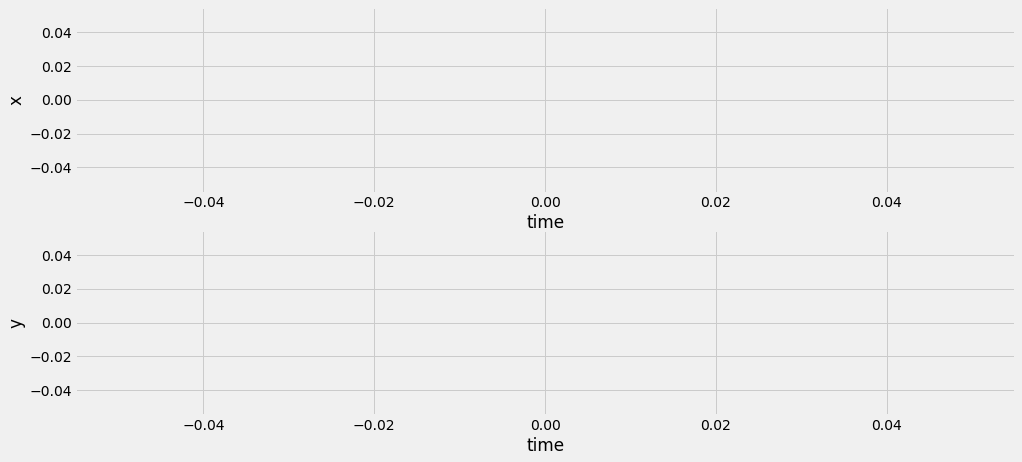

In [28]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="x", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="y", data=ped00, ax=axes[1])

In [170]:
ped00["xdiff"] = ped00["x"].diff(1)
ped00["xdiff"].fillna(0, inplace=True)

In [172]:
ped00["ydiff"] = ped00["y"].diff(1)
ped00["ydiff"].fillna(0, inplace=True)

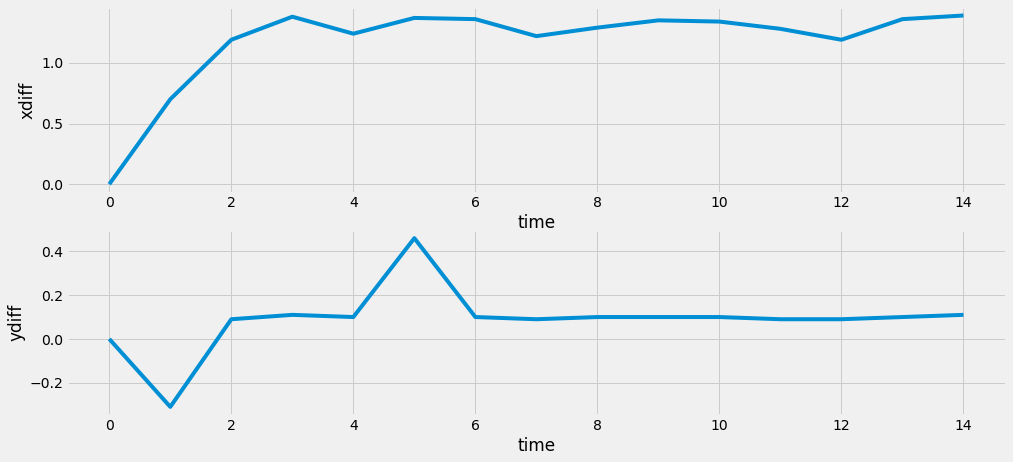

In [173]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x="time", y="xdiff", data=ped00, ax=axes[0])
sns.lineplot(x="time", y="ydiff", data=ped00, ax=axes[1])

## Training

In [174]:
data_list = list()
max_length = 0
for _, segment in ped0.groupby("id"):
    segment = segment.copy(deep=True).reset_index(drop=True)
    # segment["x"] = np.log(segment["x"])
    # segment["y"] = np.log(segment["y"])
    segment["xdiff"] = segment["x"].diff(1)
    segment["xdiff"].fillna(0, inplace=True)
    segment["ydiff"] = segment["y"].diff(1)
    segment["ydiff"].fillna(0, inplace=True)
    data_input = segment[["xdiff","ydiff"]].values
    data_input = normalize(data_input, axis=0)
    data_input = np.reshape(data_input, (-1, 2))
    data_list.append(data_input)

In [175]:
padded_data = pad_sequences(data_list, maxlen=None, dtype="float32", padding="post", value=-5.0)
print(padded_data.shape)

(26, 155, 2)


In [176]:
X = padded_data[:, :-1, :]
Y = padded_data[:, 1:, :]
print(X.shape)
print(Y.shape)

(26, 154, 2)
(26, 154, 2)


In [177]:
# The LSTM architecture
regressor = Sequential()
# Masking layer
regressor.add(Masking(mask_value=-5.0, input_shape=(X.shape[1], X.shape[2])))
# LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True,))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=2))
print(regressor.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_7 (Masking)          (None, 154, 2)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 154, 50)           10600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 154, 50)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 154, 2)            102       
Total params: 10,702
Trainable params: 10,702
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [179]:
# Fitting to the training set
regressor.fit(X, Y, epochs=500, batch_size=16)

Epoch 1/500
26/26 [==============================] - 3s 102ms/step - loss: 1.1967
Epoch 2/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2722
Epoch 3/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2620
Epoch 4/500
26/26 [==============================] - 0s 7ms/step - loss: 1.1596
Epoch 5/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1588
Epoch 6/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1708
Epoch 7/500
26/26 [==============================] - ETA: 0s - loss: 1.773 - 0s 8ms/step - loss: 1.3711
Epoch 8/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3232
Epoch 9/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2576
Epoch 10/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3415
Epoch 11/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3139
Epoch 12/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1800
Epoch 13/50

26/26 [==============================] - 0s 8ms/step - loss: 0.9836
Epoch 102/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9962
Epoch 103/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9798
Epoch 104/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9780
Epoch 105/500
26/26 [==============================] - 0s 9ms/step - loss: 1.0096
Epoch 106/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9986
Epoch 107/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2431
Epoch 108/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0142
Epoch 109/500
26/26 [==============================] - 0s 8ms/step - loss: 1.1265
Epoch 110/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1221
Epoch 111/500
26/26 [==============================] - 0s 10ms/step - loss: 1.4449
Epoch 112/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9969
Epoch 113/500
26/26 [========

26/26 [==============================] - 0s 7ms/step - loss: 1.1149
Epoch 202/500
26/26 [==============================] - 0s 7ms/step - loss: 1.1403
Epoch 203/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3893
Epoch 204/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0512
Epoch 205/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3773
Epoch 206/500
26/26 [==============================] - 0s 7ms/step - loss: 1.4177
Epoch 207/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9685
Epoch 208/500
26/26 [==============================] - 0s 8ms/step - loss: 1.3601
Epoch 209/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9453
Epoch 210/500
26/26 [==============================] - 0s 8ms/step - loss: 1.0150
Epoch 211/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9409
Epoch 212/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9521
Epoch 213/500
26/26 [=========

26/26 [==============================] - 0s 7ms/step - loss: 1.1208
Epoch 302/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9480
Epoch 303/500
26/26 [==============================] - 0s 7ms/step - loss: 1.7261
Epoch 304/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9481
Epoch 305/500
26/26 [==============================] - 0s 8ms/step - loss: 0.8575
Epoch 306/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9425
Epoch 307/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9421
Epoch 308/500
26/26 [==============================] - 0s 8ms/step - loss: 0.9651
Epoch 309/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9201
Epoch 310/500
26/26 [==============================] - 0s 7ms/step - loss: 0.9348
Epoch 311/500
26/26 [==============================] - 0s 7ms/step - loss: 1.5269
Epoch 312/500
26/26 [==============================] - 0s 7ms/step - loss: 0.8749
Epoch 313/500
26/26 [=========

26/26 [==============================] - 0s 8ms/step - loss: 1.3087
Epoch 402/500
26/26 [==============================] - 0s 8ms/step - loss: 1.8303
Epoch 403/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9725
Epoch 404/500
26/26 [==============================] - 0s 9ms/step - loss: 1.2796
Epoch 405/500
26/26 [==============================] - 0s 11ms/step - loss: 1.3319
Epoch 406/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1832
Epoch 407/500
26/26 [==============================] - 0s 8ms/step - loss: 1.2684
Epoch 408/500
26/26 [==============================] - 0s 8ms/step - loss: 2.0762
Epoch 409/500
26/26 [==============================] - 0s 9ms/step - loss: 1.2470
Epoch 410/500
26/26 [==============================] - 0s 9ms/step - loss: 1.1410
Epoch 411/500
26/26 [==============================] - 0s 9ms/step - loss: 1.0701
Epoch 412/500
26/26 [==============================] - 0s 9ms/step - loss: 0.9818
Epoch 413/500
26/26 [========

26/26 [==============================] - 0s 8ms/step - loss: 0.8117


In [180]:
predicted = regressor.predict(X[0:1])
mask = X[0:1] != -5.0
predicted = predicted[mask].reshape(1, -1, 2)
print(predicted)

[[[-0.1924711  -0.23096237]
  [-0.3269438  -0.45380038]
  [-0.19613889 -0.34801644]
  [-0.06487506 -0.23120707]
  [ 0.04048561 -0.12994644]
  [ 0.23773499  0.13957414]
  [ 0.18570714  0.08653447]
  [ 0.114195    0.01554939]
  [ 0.01824257 -0.08420032]
  [-0.12053305 -0.23371348]
  [-0.335078   -0.46530706]
  [-0.7232804  -0.87972724]
  [-1.578091   -1.7671742 ]
  [-3.8599057  -4.091867  ]
  [-6.297168   -6.5445848 ]]]


In [181]:
true_value = Y[0:1][mask].reshape(1, -1, 2)
print(true_value)

[[[ 0.14698164 -0.4759104 ]
  [ 0.2498688   0.13816753]
  [ 0.2897638   0.16887143]
  [ 0.26036748  0.15351948]
  [ 0.2876641   0.7061896 ]
  [ 0.28556433  0.15351948]
  [ 0.256168    0.13816753]
  [ 0.2708662   0.15351948]
  [ 0.2834646   0.15351948]
  [ 0.28136486  0.15351948]
  [ 0.26876643  0.13816753]
  [ 0.2498688   0.13816753]
  [ 0.28556433  0.15351948]
  [ 0.29186356  0.16887143]
  [-5.         -5.        ]]]


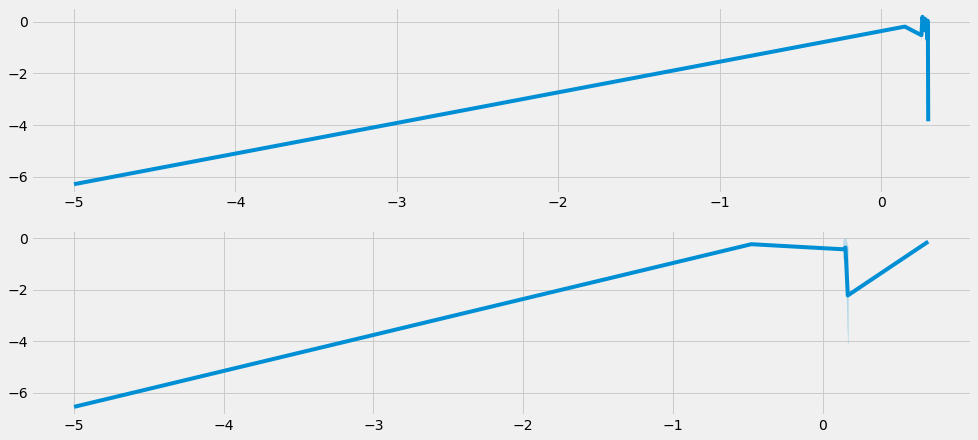

In [182]:
f, axes = plt.subplots(2, 1)
sns.lineplot(x=true_value[0, :, 0], y=true_value[0, :, 1], ax=axes[0])
sns.lineplot(x=predicted[0, :, 0], y=predicted[0, :, 1], ax=axes[1])